In [111]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import sys
from layers import InputToCx, CxMO, FreeSpacePropagation, CxD2NNIntensity, CxD2NNMNISTDetector

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)
print("OpenCV:", cv2.__version__)

plt.rcParams['font.size'] = 18

TensorFlow: 2.0.0
Python: 3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 12:58:59) 
[GCC Clang 10.0.0 ]
OpenCV: 3.4.2


shape : ((rcp or lcp), (x_real, x_image, y_real, y_image), width, height)
右ねじが進む方向で正

In [113]:
l = 633.0e-9
k = 2 * np.pi / l

shape = (10, 10)
inputs = keras.Input(shape)
x = InputToCx(shape)(inputs)
x = CxMO(shape)(x)
x = FreeSpacePropagation(shape, k, 0.5e-3)(x)
x = CxMO(shape)(x)
x = CxD2NNIntensity(shape)(x)

model = tf.keras.Model(inputs, x)
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 10, 10)]          0         
_________________________________________________________________
input_to_cx_26 (InputToCx)   (None, 2, 4, 10, 10)      0         
_________________________________________________________________
cx_mo_27 (CxMO)              (None, 2, 4, 10, 10)      100       
_________________________________________________________________
free_space_propagation_25 (F (None, 2, 4, 10, 10)      0         
_________________________________________________________________
cx_mo_28 (CxMO)              (None, 2, 4, 10, 10)      100       
_________________________________________________________________
cx_d2nn_intensity_4 (CxD2NNI (None, 10, 10)            0         
Total params: 200
Trainable params: 200
Non-trainable params: 0
____________________________________________________________

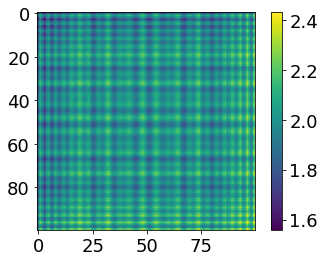

In [103]:
pt1 = np.loadtxt('./data/phase/100px/train_7.csv')
pt2 = np.loadtxt('./data/phase/100px/train_5.csv')
pt3 = np.loadtxt('./data/phase/100px/periodic_dot1.csv')
pt = np.array([pt1, pt2, pt3])
pt[pt == 1] = 4 * np.pi / 180
pt[pt == 0] = -4 * np.pi / 180

model.layers[2].set_weights([pt[0,:,:]])

test_pat = np.ones(shape=shape)
pred = model.predict(np.array([test_pat]))
pred.shape

rcp_x = pred[0, 0, 0:2, :, :]
rcp_y = pred[0, 0, 2:4, :, :]
lcp_x = pred[0, 1, 0:2, :, :]
lcp_y = pred[0, 1, 2:4, :, :]

E0 = rcp_x + lcp_x
I0 = E0[0,:,:]**2 + E0[1,:,:]**2
E90 = rcp_y + lcp_y
I90 = E90[0,:,:]**2 + E90[1,:,:]**2
E45_x = (rcp_x + rcp_y + lcp_x + lcp_y) / 2
E45_y = (rcp_x + rcp_y + lcp_x + lcp_y) / 2
I45 = E45_x[0,:,:]**2 + E45_x[1,:,:]**2 + E45_y[0,:,:]**2 + E45_y[1,:,:]**2
E135_x = (rcp_x - rcp_y + lcp_x - lcp_y) / 2
E135_y = (-rcp_x + rcp_y - lcp_x + lcp_y) / 2
I135 = E135_x[0,:,:]**2 + E135_x[1,:,:]**2 + E135_y[0,:,:]**2 + E135_y[1,:,:]**2
E_tot_x = rcp_x + lcp_x
E_tot_y = rcp_y + lcp_y
E_tot = E_tot_x[0,:,:]**2 + E_tot_x[1,:,:]**2 + E_tot_y[0,:,:]**2 + E_tot_y[1,:,:]**2

S0 = (I0 + I90 + I45 + I135)/2
S1 = I0 - I90
S2 = I45 - I135
theta = tf.atan(S2/S1)/2
plt.imshow(theta * 180 / np.pi)
plt.colorbar()

array([[0.9999999, 0.9999999, 0.9999999, ..., 0.9999999, 0.9999999,
        0.9999999],
       [0.9999999, 0.9999999, 0.9999999, ..., 0.9999999, 0.9999999,
        0.9999999],
       [0.9999999, 0.9999999, 0.9999999, ..., 0.9999999, 0.9999999,
        0.9999999],
       ...,
       [0.9999999, 0.9999999, 0.9999999, ..., 0.9999999, 0.9999999,
        0.9999999],
       [0.9999999, 0.9999999, 0.9999999, ..., 0.9999999, 0.9999999,
        0.9999999],
       [0.9999999, 0.9999999, 0.9999999, ..., 0.9999999, 0.9999999,
        0.9999999]], dtype=float32)

In [6]:
class CxD2NNEllipticity(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(CxD2NNEllipticity, self).__init__(**kwargs)
        self.output_dim = output_dim

    def call(self, x, **kwargs):
        x_rcp_real = Lambda(lambda x: x[:,0, 0, :, :])(x)
        x_rcp_imag = Lambda(lambda x: x[:,0, 1, :, :])(x)
        x_lcp_real = Lambda(lambda x: x[:,1, 0, :, :])(x)
        x_lcp_imag = Lambda(lambda x: x[:,1, 1, :, :])(x)
        i_rcp = tf.sqrt(x_rcp_real ** 2 + x_rcp_imag ** 2)
        i_lcp = tf.sqrt(x_lcp_real ** 2 + x_lcp_imag ** 2)
        ellipticity = (i_rcp - i_lcp)/(i_rcp + i_lcp)

        return ellipticity

In [11]:
class CxD2NNFarraday(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(CxD2NNFarraday, self).__init__(**kwargs)
        self.output_dim = output_dim

    def call(self, x, **kwargs):
        x_rcp_real = Lambda(lambda x: x[:,0, 0, :, :])(x)
        x_rcp_imag = Lambda(lambda x: x[:,0, 1, :, :])(x)
        x_lcp_real = Lambda(lambda x: x[:,1, 0, :, :])(x)
        x_lcp_imag = Lambda(lambda x: x[:,1, 1, :, :])(x)
        a = tf.sqrt(x_rcp_real**2 + x_rcp_imag**2) + tf.sqrt(x_lcp_real**2 + x_lcp_imag**2)
        b = tf.sqrt(x_rcp_real**2 + x_rcp_imag**2) - tf.sqrt(x_lcp_real**2 + x_lcp_imag**2)
        r = tf.sqrt((x_rcp_real + x_lcp_real)**2 + (x_rcp_imag + x_lcp_imag)**2)
        theta = tf.asin(tf.sqrt(a**2 * b**2 / ((a**2 + b**2) * r**2) - b**2 / (a**2 + b**2))) - tf.asin(-(x_rcp_real + x_rcp_real) / r)

        return theta

In [9]:
def create_true_mnistimage(label, shape):
    width = min(int(np.floor(shape[1] / 9.0)), int(np.floor(shape[0] / 7.0)))
    height = min(int(np.floor(shape[1] / 9.0)), int(np.floor(shape[0] / 7.0)))
    x = np.zeros(shape)

    if label == 0:
        x[2 * height:3 * height, width:2 * width] = 1.0
    elif label == 1:
        x[2 * height:3 * height, 4 * width:5 * width] = 1.0
    elif label == 2:
        x[2 * height:3 * height, 7 * width:8 * width] = 1.0
    elif label == 3:
        x[4 * height:5 * height, 1 * width:2 * width] = 1.0
    elif label == 4:
        x[4 * height:5 * height, 3 * width:4 * width] = 1.0
    elif label == 5:
        x[4 * height:5 * height, 5 * width:6 * width] = 1.0
    elif label == 6:
        x[4 * height:5 * height, 7 * width:8 * width] = 1.0
    elif label == 7:
        x[6 * height:7 * height, width:2 * width] = 1.0
    elif label == 8:
        x[6 * height:7 * height, 4 * width:5 * width] = 1.0
    elif label == 9:
        x[6 * height:7 * height, 7 * width:8 * width] = 1.0

    return x

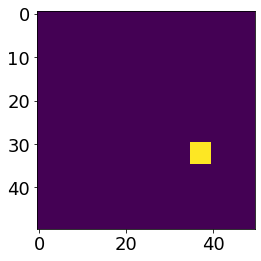

In [10]:
plt.imshow(create_true_mnistimage(9, (50, 50)))

In [9]:
mnist = tf.keras.datasets.mnist

image_shape = (28, 28)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.array(list(map(lambda image: cv2.resize(image, dsize=image_shape), x_train)))
x_test = np.array(list(map(lambda image: cv2.resize(image, dsize=image_shape), x_test)))
y_train_image = np.array(list(map(lambda y_label: create_true_mnistimage(y_label, image_shape), y_train)))
y_test_image = np.array(list(map(lambda y_label: create_true_mnistimage(y_label, image_shape), y_test)))
x_train = x_train / 255.0
x_test = x_test / 255.0

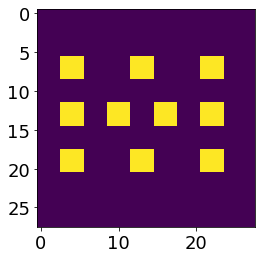

In [12]:
detector = CxD2NNMNISTDetector(10)
detector.plot_area((28, 28), same_color=True)

In [10]:
def loss(y_hat, y):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_hat, logits=y)


def loss_MSE(y_hat, y):
    return tf.reduce_sum((y_hat - y) ** 2)

In [10]:
l = 633e-9
k = 2 * np.pi / l
d = 1e-6

In [18]:
inputs = keras.Input(image_shape)
x = InputToCx(image_shape)(inputs)
x = CxMO(image_shape)(x)
x = FreeSpacePropagation(image_shape, k, 1.0e-4, normalization='max', input_pitch=2.0e-6, output_pitch=2.0e-6)(x)
x = CxD2NNIntensity(image_shape, normalization='max')(x)
x = CxD2NNMNISTDetector(10, activation='softmax')(x)
model = tf.keras.Model(inputs, x)
model.summary()
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",  # category: sparse_categorical_crossentropy
              metrics=['accuracy'])

epochs = 10
early_stopping = EarlyStopping(
    monitor='accuracy',
    min_delta=0.05,
    patience=2,
)

result = model.fit(x_train,
                   y_train,
                   batch_size=64,
                   epochs=epochs
                   #callbacks=[early_stopping]
                   )
model.save("28x28_6(MO_frspc100um)")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
input_to_cx_1 (InputToCx)    (None, 2, 2, 28, 28)      0         
_________________________________________________________________
cx_mo_1 (CxMO)               (None, 2, 2, 28, 28)      784       
_________________________________________________________________
free_space_propagation_1 (Fr (None, 2, 2, 28, 28)      1229312   
_________________________________________________________________
cx_d2nn_intensity (CxD2NNInt (None, 28, 28)            0         
_________________________________________________________________
cx_d2nnmnist_detector_1 (CxD (None, 10)                0         
Total params: 1,230,096
Trainable params: 784
Non-trainable params: 1,229,312
_______________________________________________

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, epochs + 1), result.history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, epochs + 1), result.history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden_layer_model.summary()

In [ ]:
num = 5
images = x_train[0:num, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
fig, axes = plt.subplots(num, 3, figsize=(7, 10))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 2].set_xticks(np.arange(0, 10, 1))
    axes[i, 2].set_ylabel('Accuracy')
fig.tight_layout()

In [ ]:
layer_outputs = [layer.output for layer in model.layers[1:]]
layer_outputs

In [ ]:
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
activation_model.summary()

In [ ]:
num = 5
images = x_train[0:num, :, :]
activations = activation_model.predict(images)
len(activations)

In [ ]:
fig, axes = plt.subplots(num, len(activations) - 2, figsize=(2 * len(activations) - 1, 2 * num))
for i in range(len(activations) - 2):
    layer_activation = activations[i]
    for j in range(num):
        intensity = tf.sqrt(layer_activation[j, 0, :, :] ** 2 + layer_activation[j, 1, :, :] ** 2)
        axes[j, i].imshow(intensity)

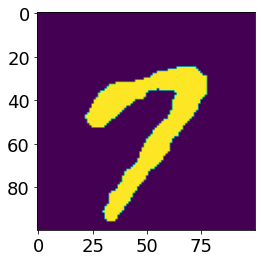

In [14]:
# ---------------------------------------------------------
pt = np.loadtxt('./data/phase/100px/train_7.csv')
pt[pt == 1] = 4 * np.pi / 180
pt[pt == 0] = -4 * np.pi / 180
plt.imshow(pt)

In [18]:
shpae = (100, 100)
inputs = keras.Input(shpae)
x = InputToCx(shpae)(inputs)
x = CxMO(shpae)(x)
# x = FreeSpacePropagation(shpae, k, 0.5e-3)(x)
x = CxD2NNFarraday(shpae)(x)

model = tf.keras.Model(inputs, x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
input_to_cx_1 (InputToCx)    (None, 2, 2, 100, 100)    0         
_________________________________________________________________
cx_mo_1 (CxMO)               (None, 2, 2, 100, 100)    10000     
_________________________________________________________________
cx_d2nn_farraday_1 (CxD2NNFa (None, 100, 100)          0         
Total params: 10,000
Trainable params: 10,000
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.layers[2].set_weights([pt])

In [20]:
beam = np.ones(shape=shpae)
pred = model.predict(np.array([beam]))
pred.shape

(1, 100, 100)

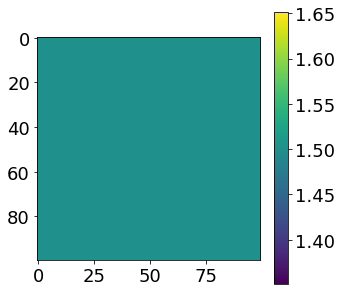

In [21]:
plt.figure(figsize=(5,5))
plt.imshow(pred[0,:,:])
plt.colorbar()